In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amdgoogle/AMD.csv
/kaggle/input/amdgoogle/GOOGL.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
dataset = pd.DataFrame(pd.read_csv("/kaggle/input/amdgoogle/AMD.csv"))

In [4]:
dataset.shape

(2335, 7)

In [5]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-05-22,4.43,4.43,4.25,4.26,4.26,8274300
1,2009-05-26,4.26,4.57,4.23,4.53,4.53,16094300
2,2009-05-27,4.57,4.80,4.55,4.71,4.71,21512600
3,2009-05-28,4.75,4.84,4.54,4.70,4.70,18383900
4,2009-05-29,4.71,4.78,4.38,4.54,4.54,24539700


In [6]:
dataset.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2330,2018-08-23,21.190001,22.320000,21.139999,22.290001,22.290001,113444100
2331,2018-08-24,22.910000,24.000000,22.670000,23.980000,23.980000,164328200
2332,2018-08-27,24.940001,27.299999,24.629999,25.260000,25.260000,325058400
2333,2018-08-28,25.510000,26.180000,24.040001,25.049999,25.049999,215771200
2334,2018-08-29,24.360001,25.410000,24.010000,25.200001,25.200001,143079800


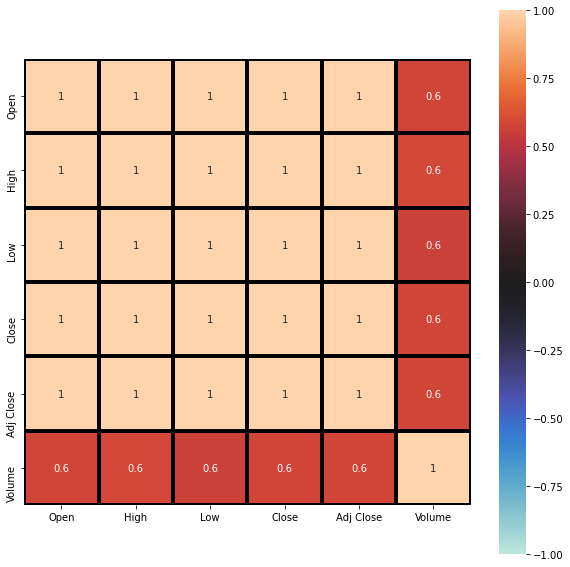

In [7]:
# check for any correlation
plt.figure(figsize = (10,10))
sns.heatmap(dataset.corr(), annot = True, fmt = ".1g", vmin = -1, vmax = 1, center = 0, linewidth = 3,
           linecolor = "black", square = True)

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2335 non-null   object 
 1   Open       2335 non-null   float64
 2   High       2335 non-null   float64
 3   Low        2335 non-null   float64
 4   Close      2335 non-null   float64
 5   Adj Close  2335 non-null   float64
 6   Volume     2335 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 127.8+ KB


There is no missing value. We have full entry.

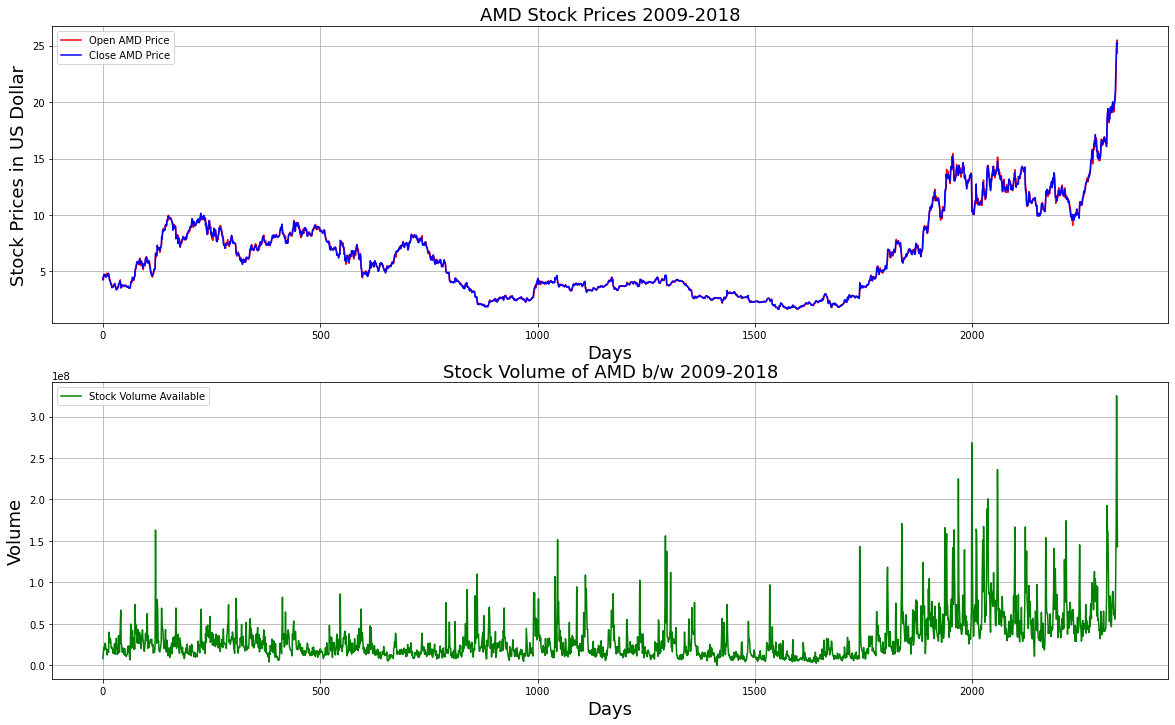

In [9]:
plt.figure(figsize = (20, 12))
x = np.arange(0, dataset.shape[0], 1)
plt.subplot(2,1,1)
plt.plot(x, dataset.Open.values, color = "red", label = "Open AMD Price")
plt.plot(x, dataset.Close.values, color = "blue", label = "Close AMD Price")
plt.title("AMD Stock Prices 2009-2018", fontsize = 18)
plt.xlabel("Days", fontsize = 18)
plt.ylabel("Stock Prices in US Dollar", fontsize = 18)
plt.legend(loc = "best")
plt.grid(which = "major", axis = "both")

plt.subplot(2,1,2)
plt.plot(x, dataset.Volume.values, color = "green", label = "Stock Volume Available")
plt.title("Stock Volume of AMD b/w 2009-2018", fontsize = 18)
plt.xlabel("Days", fontsize = 18)
plt.ylabel("Volume", fontsize = 18)
plt.legend(loc = "best")
plt.grid(which = "major", axis = "both")
plt.show()

In [10]:
TIME_STEP = 7
DAYS = 20 # number of days at the end for which we have to predict. These will be in our validation set.

In [11]:
dataset = pd.DataFrame(pd.read_csv("/kaggle/input/amdgoogle/AMD.csv"))

In [12]:
def dataset_split(dataset) : 
    train = dataset[0: len(dataset) - DAYS]
    val = dataset[len(dataset) - DAYS - TIME_STEP : len(dataset)]
    return train, val

In [13]:
dataset.drop(["Date","High", "Low", "Close", "Volume", "Adj Close"], axis = 1, inplace = True)
dataset = dataset.values

In [14]:
import sklearn
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
dataset_scaled = scaler.fit_transform(dataset)

In [15]:
train, val = dataset_split(dataset_scaled)

In [16]:
train.shape, val.shape

((2315, 1), (27, 1))

In [17]:
train_x, train_y = [], []
for i in range(TIME_STEP, train.shape[0]) : 
    train_x.append(train[i - TIME_STEP : i, 0])
    train_y.append(train[i, 0])
train_x, train_y = np.array(train_x), np.array(train_y)

In [18]:
val_x, val_y = [], []
for i in range(TIME_STEP, val.shape[0]) : 
    val_x.append(val[i - TIME_STEP : i, 0])
    val_y.append(val[i, 0])
val_x, val_y = np.array(val_x), np.array(val_y)

In [19]:
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
val_x = np.reshape(val_x, (val_x.shape[0], val_x.shape[1], 1))
print("Reshaped train_x = ", train_x.shape)
print("Shape of train_y = ", train_y.shape)

print("Reshaped val_x = ", val_x.shape)
print("Shape of val_y = ", val_y.shape)

Reshaped train_x =  (2308, 7, 1)
Shape of train_y =  (2308,)
Reshaped val_x =  (20, 7, 1)
Shape of val_y =  (20,)


In [20]:
import tensorflow as tf

In [21]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.list_physical_devices("GPU")
print(gpus)
if len(gpus) == 1 : 
    strategy = tf.distribute.OneDeviceStrategy(device = "/gpu:0")
else:
    strategy = tf.distribute.MirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision" : True})
print("Mixed precision enabled")

Mixed precision enabled


In [23]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= "loss", factor = 0.5, patience = 10,
                                                 min_lr = 0.000001, verbose = 1)
monitor_es = tf.keras.callbacks.EarlyStopping(monitor= "loss", patience = 25, restore_best_weights= False, verbose = True)

In [24]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units = 128, return_sequences = True, input_shape = (train_x.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(units = 128, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(units = 128, return_sequences = False))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(units = 10, activation = "relu"))
model.add(tf.keras.layers.Dense(units = 1, activation = "relu"))

In [25]:
model.compile(tf.keras.optimizers.Adam(lr = 0.001), loss = "mean_squared_error")

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 128)            66560     
_________________________________________________________________
dropout (Dropout)            (None, 7, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 128)            131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

In [27]:
with tf.device("/device:GPU:0"):
    history = model.fit(train_x, train_y, epochs = 300, batch_size = 16, callbacks = [reduce_lr, monitor_es])

Epoch 1/300
145/145 [==============================] - 1s 7ms/step - loss: 0.0037 - lr: 0.0010
Epoch 2/300
145/145 [==============================] - 1s 7ms/step - loss: 0.0012 - lr: 0.0010
Epoch 3/300
145/145 [==============================] - 1s 6ms/step - loss: 0.0011 - lr: 0.0010
Epoch 4/300
145/145 [==============================] - 1s 6ms/step - loss: 9.6641e-04 - lr: 0.0010
Epoch 5/300
145/145 [==============================] - 1s 6ms/step - loss: 0.0010 - lr: 0.0010
Epoch 6/300
145/145 [==============================] - 1s 6ms/step - loss: 9.0483e-04 - lr: 0.0010
Epoch 7/300
145/145 [==============================] - 1s 6ms/step - loss: 8.2150e-04 - lr: 0.0010
Epoch 8/300
145/145 [==============================] - 1s 6ms/step - loss: 7.9316e-04 - lr: 0.0010
Epoch 9/300
145/145 [==============================] - 1s 6ms/step - loss: 7.9330e-04 - lr: 0.0010
Epoch 10/300
145/145 [==============================] - 1s 7ms/step - loss: 7.8827e-04 - lr: 0.0010
Epoch 11/300
145/145 [===

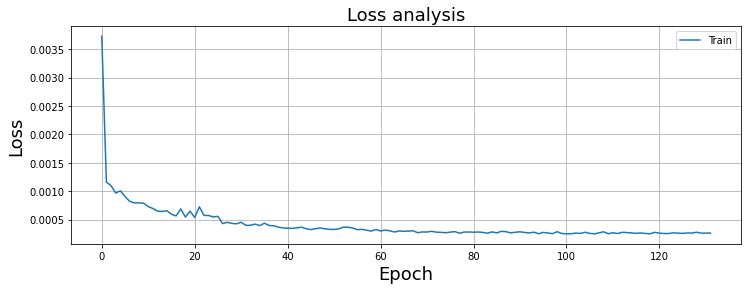

In [28]:
plt.figure(figsize = (12, 4))
plt.plot(history.history["loss"], label = "Training loss")
plt.title("Loss analysis", fontsize = 18)
plt.xlabel("Epoch", fontsize = 18)
plt.ylabel("Loss", fontsize = 18)
plt.legend(["Train"])
plt.grid("both")

In [29]:
real_prices = val[TIME_STEP:]
real_prices = scaler.inverse_transform(real_prices)

In [30]:
predicted_prices = model.predict(val_x)
predicted_prices = scaler.inverse_transform(predicted_prices)

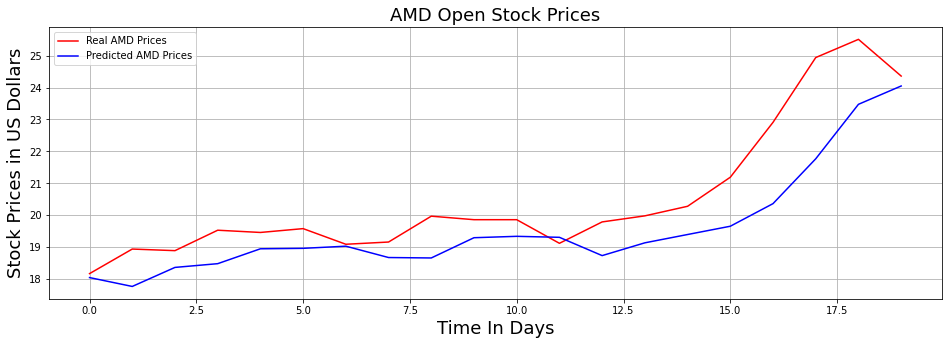

In [31]:
plt.figure(figsize= (16, 5))
plt.subplot(1,1,1)

x = np.arange(0, DAYS, 1)

plt.plot(x, real_prices, color = "red", label = "Real AMD Prices")
plt.plot(x, predicted_prices, color = "blue", label = "Predicted AMD Prices")
plt.title("AMD Open Stock Prices", fontsize = 18)
plt.xlabel("Time In Days", fontsize = 18)
plt.ylabel("Stock Prices in US Dollars", fontsize = 18)
plt.legend()
plt.grid("both")

In [32]:
original_training_prices = scaler.inverse_transform(train)
original_training_prices

array([[ 4.43],
       [ 4.26],
       [ 4.57],
       ...,
       [19.4 ],
       [19.35],
       [18.34]])

In [33]:
x1 = np.arange(0,len(original_training_prices),1)
x2 = np.arange(len(original_training_prices), len(dataset), 1)
print(len(x1), len(x2))

2315 20


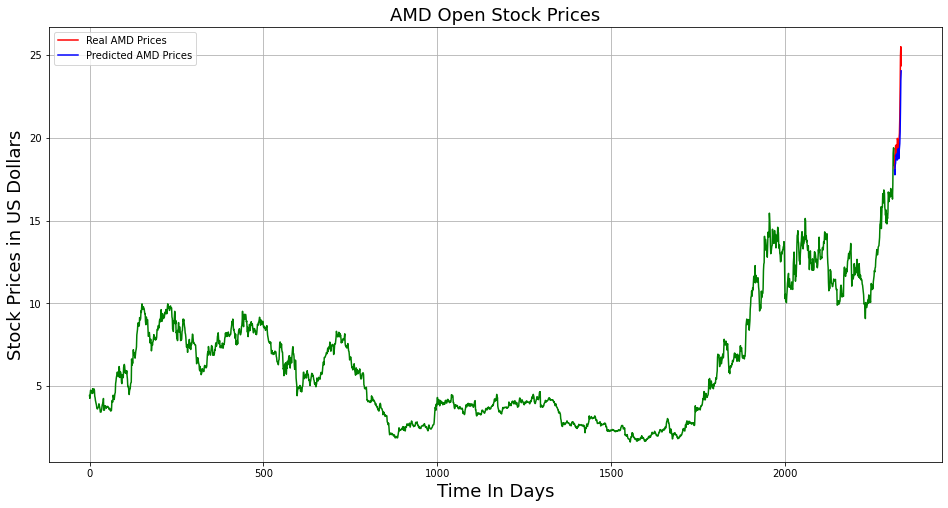

In [34]:
plt.figure(figsize= (16,8))
plt.subplot(1,1,1)

X = len(dataset)
x1 = np.arange(0,len(original_training_prices),1)
x2 = np.arange(len(original_training_prices), len(dataset), 1)

plt.plot(x1, original_training_prices, color = "green")
plt.plot(x2, real_prices, color = "red", label = "Real AMD Prices")
plt.plot(x2, predicted_prices, color = "blue", label = "Predicted AMD Prices")
plt.title("AMD Open Stock Prices", fontsize = 18)
plt.xlabel("Time In Days", fontsize = 18)
plt.ylabel("Stock Prices in US Dollars", fontsize = 18)
plt.legend()
plt.grid("both")

In [35]:
model_json = model.to_json()
with open("AMD_open_1.json", "w") as json_file:
  json_file.write(model_json)

model.save_weights("AMD_open_1.h5")